In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch

tkwargs = {"dtype": torch.float}
save_dir = "alpha_1000"
quad_strengths, image_data, bins, xx = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2
ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 100000
ensemble[0].beam.set_base_beam(
    ensemble[0].beam.base_dist,
    n_particles,
    p0c=torch.tensor(10.0e6)
)

ensemble.cuda();

/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


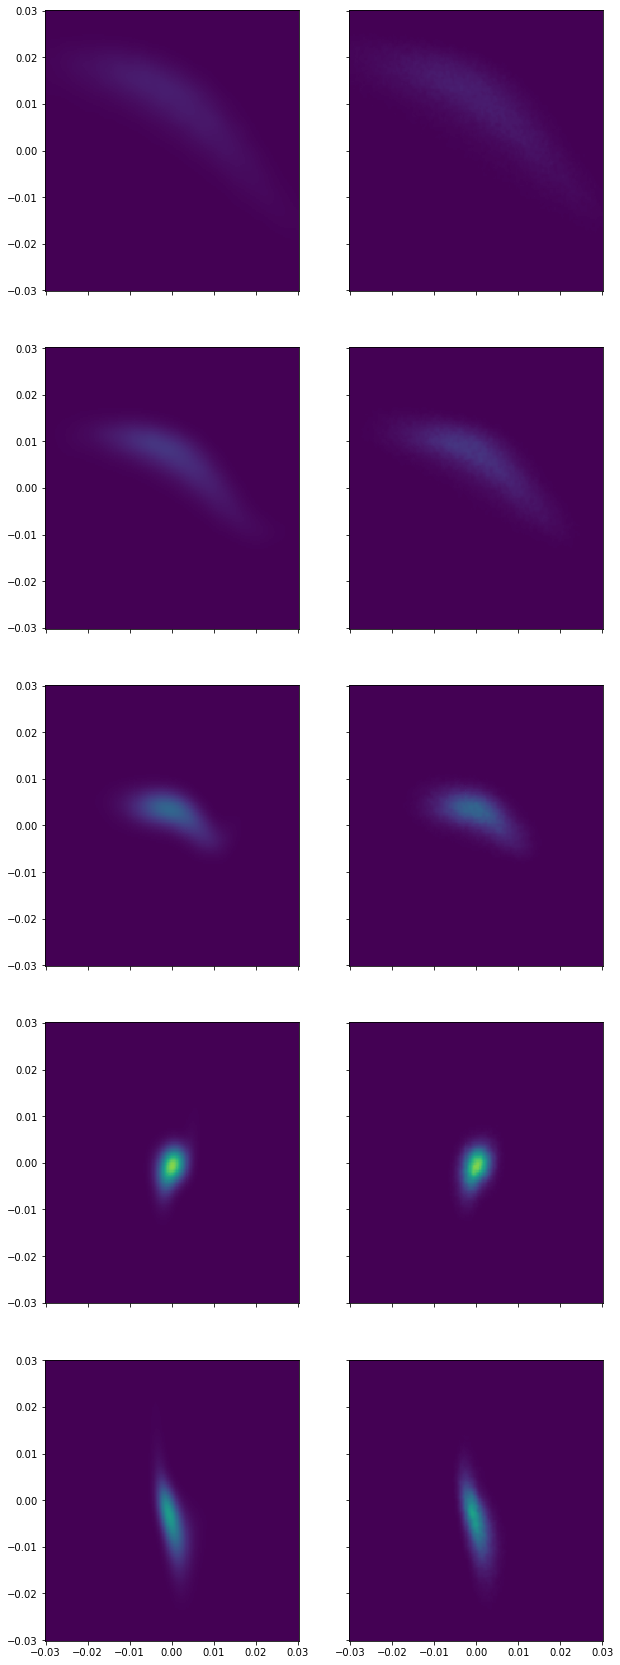

In [2]:
s = torch.arange(0,10,2)
with torch.no_grad():
    predictions, entropy = ensemble[0](train_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx, train_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.003
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.003)

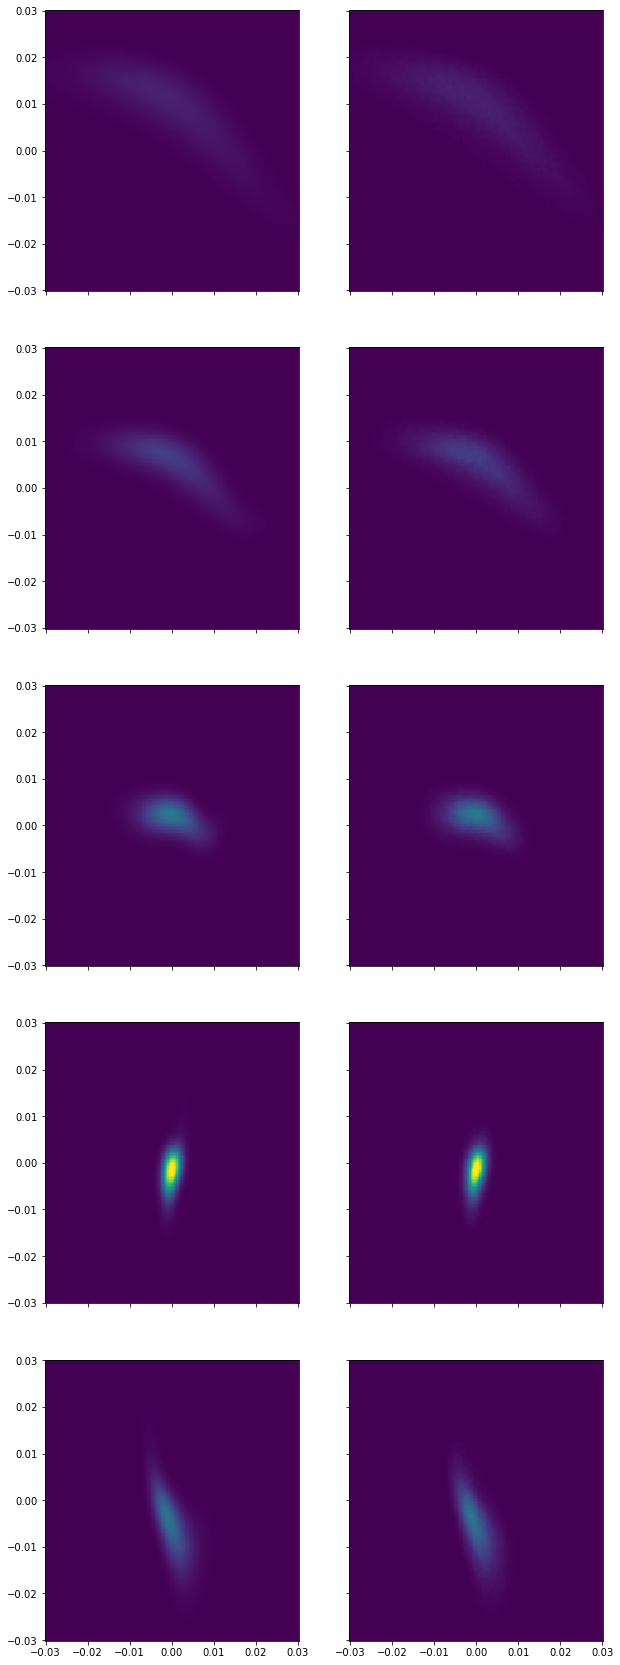

In [3]:
s = torch.arange(0,10,2)
with torch.no_grad():
    predictions, entropy = ensemble[0](test_dset[s][0].cuda())

fig,ax = plt.subplots(len(predictions),2,sharex="all", sharey="all")
fig.set_size_inches(10,30)
for i in range(len(s)):
    ax[i][0].pcolor(*xx,test_dset[s[i]][1][0].cpu().detach(),
                    vmin=0,vmax=0.003
                    )
    ax[i][1].pcolor(*xx,predictions[i][0].cpu().detach(), vmin=0,vmax=0.003)

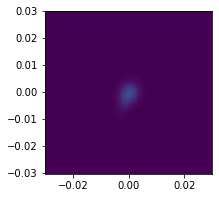

In [4]:
# zero quad strength
with torch.no_grad():
    predictions, entropy = ensemble[0](torch.zeros(1,1).cuda())

fig,ax = plt.subplots()
fig.set_size_inches(3,3)
ax.pcolor(*xx,predictions[0].cpu().detach(), vmin=0,vmax=0.01)


In [5]:
# plot loss record
loss = torch.stack(torch.load(save_dir + "/loss_log.pt"))

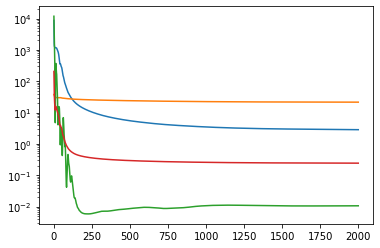

In [6]:
plt.semilogy(loss)

In [7]:
initial_beam = ensemble[0].beam()

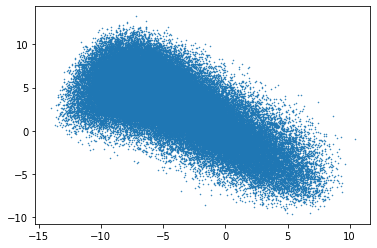

In [8]:
# propagate particles w/quad off
initial_y = initial_beam.y.cpu().detach().numpy()*1e3
initial_py = initial_beam.py.cpu().detach().numpy()*1e3

# distances
dist_to_slits = 3.38 - 2.84 + 0.12/2.0
dist_to_screen = 3.38 + 0.12/2.0

# particles
slits_y = initial_y + initial_py * dist_to_slits
slits_py = initial_py

screen_y = initial_y + initial_py * dist_to_screen
screen_py = initial_py

fig,ax=plt.subplots()
ax.plot(
    initial_y,
    initial_py,
    '.',ms=1
)

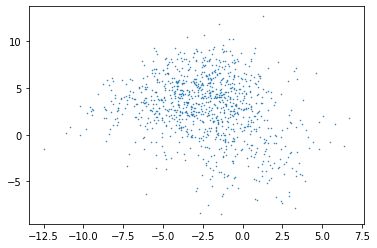

In [9]:
fig,ax=plt.subplots()
ax.plot(
    slits_y[::100], slits_py[::100],
    '.',ms=1
)

Text(0.5, 0, '$y$ (mm)')

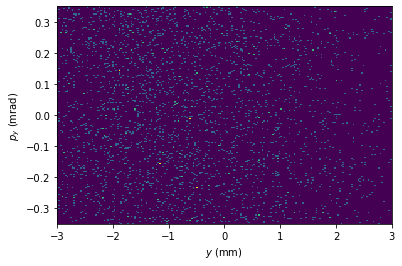

In [10]:
fig,ax=plt.subplots()
import numpy as np
# create a mesh
x = np.linspace(-3,3,200)
y = np.linspace(-0.35,0.35,200)

h, xe, ye = np.histogram2d(slits_y, slits_py, bins=[x,y])
#xc = (xe[:-1] + xe[1:]) / 2
#yc = (ye[:-1] + ye[1:]) / 2
X, Y = np.meshgrid(xe,ye)

ax.pcolor(X, Y, h.T)
ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$y$ (mm)')

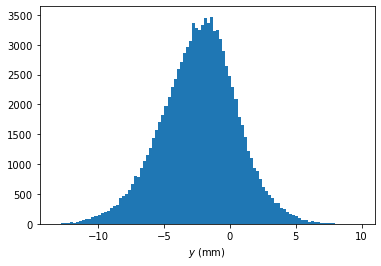

In [11]:
fig,ax=plt.subplots()
ax.hist(
    slits_y, bins=100
);
ax.set_xlabel(r"$y$ (mm)")

Text(0.5, 0, '$yp$ (mrad)')

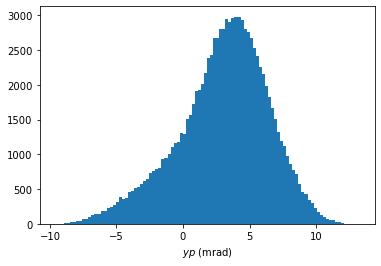

In [12]:
fig,ax=plt.subplots()
ax.hist(
    slits_py, bins=100
);
ax.set_xlabel(r"$yp$ (mrad)")

In [13]:
cov = torch.cov(initial_beam.data.T)
cov

tensor([[ 1.8116e-05, -8.9588e-06,  1.3707e-05, -9.0797e-06,  1.8940e-05,
          3.0119e-05],
        [-8.9588e-06,  5.4956e-06, -7.0915e-06,  4.9444e-06, -7.5718e-06,
         -1.5065e-05],
        [ 1.3707e-05, -7.0915e-06,  1.5230e-05, -9.3142e-06,  6.0592e-05,
          1.1705e-05],
        [-9.0797e-06,  4.9444e-06, -9.3142e-06,  1.1466e-05, -9.1697e-05,
         -6.1438e-06],
        [ 1.8940e-05, -7.5718e-06,  6.0592e-05, -9.1697e-05,  1.6565e-02,
          1.3385e-03],
        [ 3.0119e-05, -1.5065e-05,  1.1705e-05, -6.1438e-06,  1.3385e-03,
          1.1850e-03]], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [16]:
ycov = cov[2:4,2:4]
emit = torch.det(ycov).sqrt()
twiss = ycov / emit
print(f"emit {emit}")
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")

emit 9.373882676300127e-06
beta 1.6246800422668457
alpha 0.9936376214027405
gamma 1.2232043743133545


In [17]:
# geometric emittance
print(f"norm_emit: {emit*1e6} mm mrad")


norm_emit: 9.373882293701172 mm mrad


Text(0.5, 0, '$y$ (mm)')

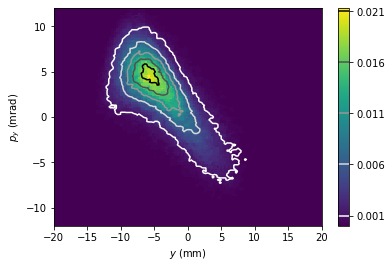

In [29]:
# compare reconstruction to slit scan measurement
import numpy as np
from scipy.ndimage import median_filter

fpath = ""

beam_coords = torch.load("synthetic_beam/ground_truth_dist.pt")
meas_y = beam_coords[:,2].cpu().numpy()*1e3
meas_yp = beam_coords[:,3].cpu().numpy()*1e3

fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
# create a mesh
x1 = np.linspace(-20,20,150)
x2 = np.linspace(-12,12,150)



h_reconstruction, xe, ye = np.histogram2d(initial_y, initial_py, bins=[x1,x2], density=True)
h_slitscan, _, _ = np.histogram2d(meas_y, meas_yp, bins=[x1,x2], density=True)

# get cdf of densities
h_dist, de  = np.histogram(h_slitscan)

# apply median filter
h_reconstruction = median_filter(h_reconstruction, 3)
h_slitscan = median_filter(h_slitscan,3)

x1c = (xe[:-1] + xe[1:]) / 2
x2c = (ye[:-1] + ye[1:]) / 2

X, Y = np.meshgrid(xe,ye)
Xc, Yc = np.meshgrid(x1c,x2c)

c1 = ax.pcolor(X, Y, h_reconstruction.T)
#ax.contour(Xc, Yc, h_reconstruction.T,levels=3)
clevels = np.arange(0.001,0.024,0.005)
c2 = ax.contour(Xc, Yc, h_slitscan.T, levels=clevels,cmap="Greys")

cbar = fig.colorbar(c1)
cbar.set_ticks(clevels)
cbar.add_lines(c2)
# add ellipse
#ax.add_patch(confidence_ellipse(ycov.cpu().detach().numpy(),1.0e3,edgecolor='red'))

ax.set_ylabel(r"$p_y$ (mrad)")
ax.set_xlabel(r"$y$ (mm)")
#fig.savefig(f"reconstruction_comparison_{save_dir}.png", dpi=300)

In [19]:
# do core analysis
initial_data = initial_beam.data[:,2:4].cpu()

# sort by distance from origin in 4D phase space
initial_norm = torch.norm(initial_data, dim=-1)
initial_data_sorted = initial_data[torch.argsort(initial_norm),:]


geo_emit: 8.30880890134722e-06
norm emit: 0.0010243738070130348
beta 1.5820945501327515
alpha 0.9685208201408386
gamma 1.224979043006897


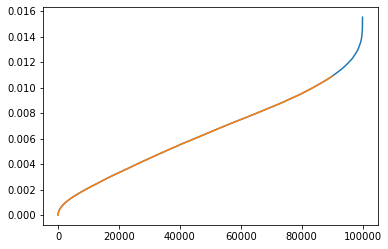

In [20]:
# get cov/emit of 95%
frac = 0.90
partial = initial_data_sorted[:int(initial_data_sorted.shape[0]*frac)]
cov = torch.cov(partial.T)

plt.plot(torch.norm(initial_data_sorted, dim=-1).detach().numpy())
plt.plot(torch.norm(partial, dim=-1).detach().numpy())

emit = torch.det(cov).sqrt()
print(f"geo_emit: {emit}")
print(f"norm emit: {emit*63.0/0.511}")

twiss = cov / emit
print(f"beta {twiss[0,0]}")
print(f"alpha {-twiss[1,0]}")
print(f"gamma {twiss[1,1]}")